## Model setup XBeach 2D

Setup a 1D XBeach model with the Python toolbox 

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os

Import the toolbox and set the xbeach styleshoot for plotting

In [2]:
## import xbeach tools
sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend, lateral_extend
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachtools import XBeachModelSetup

### Data
Load and plot the bathymetry data

D:\Users\bemc\AppData\Local\Temp\ipykernel_20996\3400537688.py:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax      = Axes3D(fig)


Text(0.5, 0.5, 'y [m]')

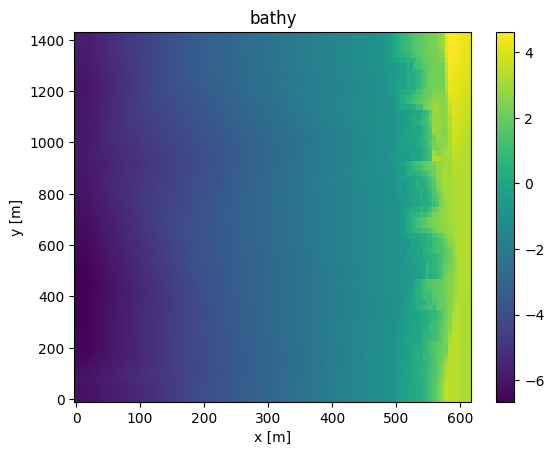

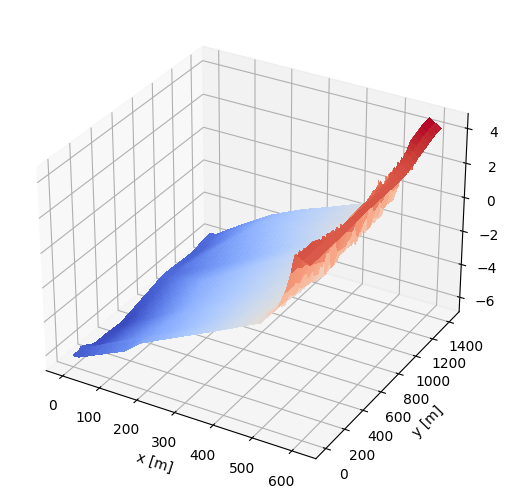

In [3]:
## load data
bathy = np.loadtxt('..//examples//data//input//bathy.dep')

## set bathy grid
nx = 124
ny = 72
dx = 5
dy = 20

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('bathy')

fig     = plt.figure()
ax      = Axes3D(fig)
surf    = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Create x-grid
Create spatially varying x-grid resolution.

Text(0, 0.5, 'z [m]')

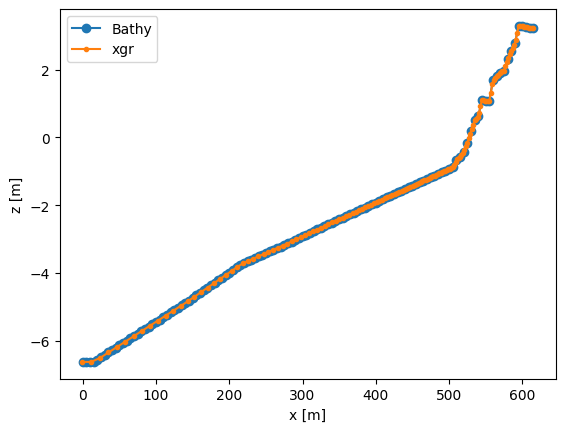

In [4]:
xgr,zgr = xgrid(x, bathy[20,:],dxmin=2)


plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Create y-grid
Create spatially varying y-grid resolution.

Enable optimization of transition distance
Area type center
Transition 142.0


d:\gitlab_folder\xbeach-toolbox\xbTools\grid\creation.py:341: RuntimeWarning: overflow encountered in power
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
d:\gitlab_folder\xbeach-toolbox\xbTools\grid\creation.py:342: RuntimeWarning: overflow encountered in scalar multiply
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
d:\gitlab_folder\xbeach-toolbox\xbTools\grid\creation.py:342: RuntimeWarning: overflow encountered in power
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
d:\gitlab_folder\xbeach-toolbox\xbTools\grid\creation.py:332: RuntimeWarning: overflow encountered in scalar multiply
  fj[1] = 1.1 * fj[1]


Text(0, 0.5, 'dy [m]')

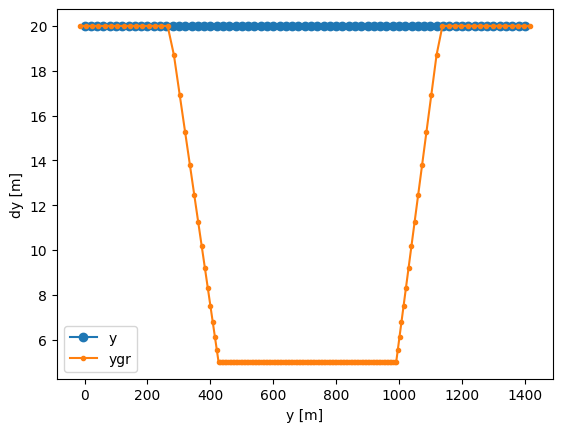

In [5]:
ygr = ygrid(y)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr[:-1],np.diff(ygr),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

### Interpolate
Interpolate data to new grid

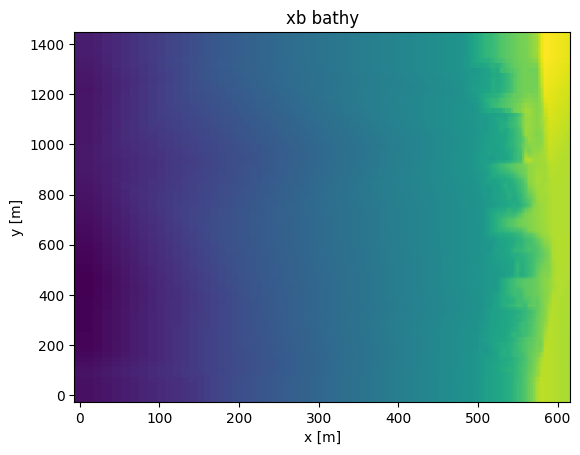

In [6]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr,ygr)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('xb bathy')


xgr, ygr = np.meshgrid(xgr,ygr)

### Seaward extend
Extend the grid to the required offshore depth. In this case 20 m with a artifial slope of 1/20.

no convergence
Artificial slope of 1:10
Hm0,shoal = 9.008451731585167
d start = 19.977837324773713
Hm0,shoal/d profile = 1.451507604860271
Hm0,shoal/d slope = 0.45092226876900976
n profile = 0.5248467628414396
n slope = 0.7776515191101054


Text(0, 0.5, 'z [m]')

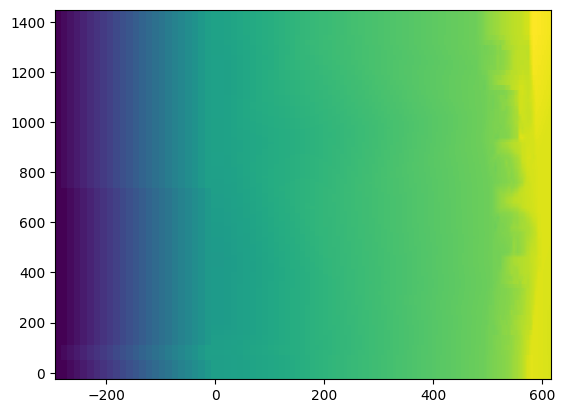

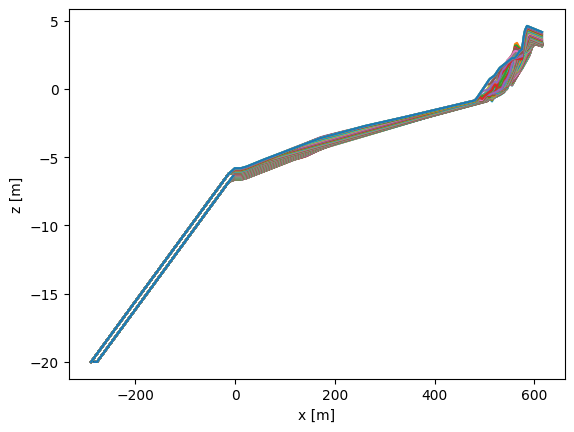

In [7]:
d_start, slope, Hm0_shoal = offshore_depth(Hm0=9, Tp=15, depth_offshore_profile=abs(bathy[0,0]), depth_boundary_conditions=20)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/20,depth=-20)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

plt.figure()
plt.plot(xgr[:,:].T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Lateral extend
Extend the grid lateral with 5 rows

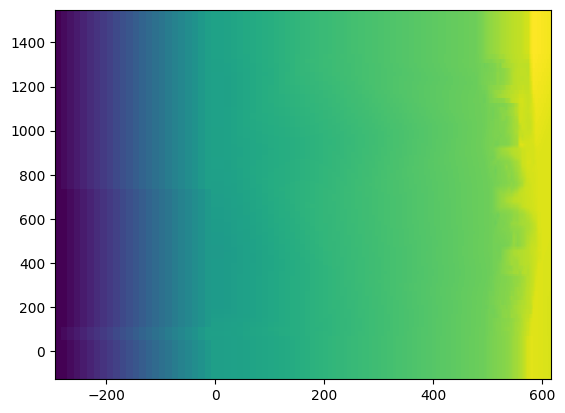

In [8]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

### Create model setup
Create the model setup class

Test som 1


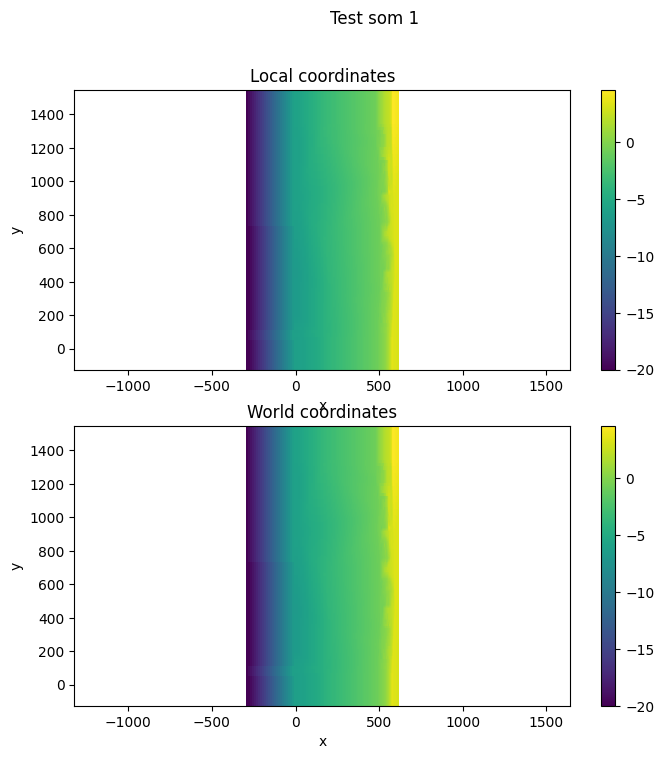

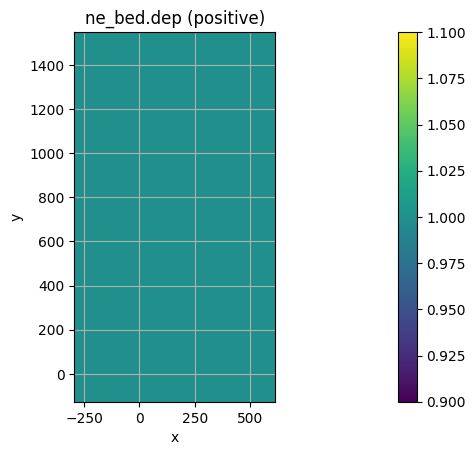

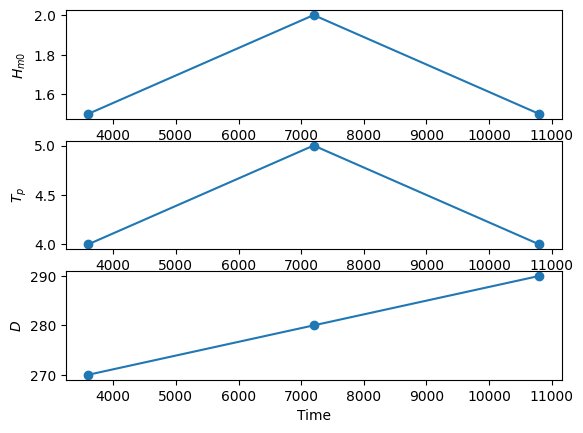

In [9]:
xb_setup = XBeachModelSetup('Test som 1')

print(xb_setup)

xb_setup.set_grid(xgr,ygr,zgr)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

#xb_setup.set_waves('jons',{'Hm0':2,'Tp':5,'gammajsp':3.3, 's' : 10000, 'mainang':270,'fnyq':1})
xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280, 290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})

xb_setup.set_params({'Wavemodel':'surfbeat',
                     'morphology':0,
                     'befriccoef':0.01,
                     'tstop':3600,
                     'zs0':0,
                     'nglobalvar':['zb','zs','H'],
                     'npointvar':['zs','H'],
                     'nmeanvar':['zb'],
                     'npoints':['1 0', '6 0', '10 0', '12 0']})


sim_path = os.path.join('xb-2D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(os.path.join(sim_path))